In [1]:
import os
import numpy as np
from scipy import fftpack
import matplotlib.pyplot as plt

In [2]:
# Generate a multi cosmology dataset    
n_sims = 5_000
n_pix = 32
box_dim = 1.


AB = np.array([1., 2.5]) # Fiducial cosmology
lower = np.array([0.1, 2.])
upper = np.array([2., 3.])
param_names = ["A", "B"]

parameters = np.stack(
    [
        np.random.uniform(low=lower[0], high=upper[0], size=n_sims),
        np.random.uniform(low=lower[1], high=upper[1], size=n_sims)
    ], 
    axis=1
)

A = parameters[:,0]
B = parameters[:,1]

pk_fn = lambda k: A * k ** -B
parameters.shape

(5000, 2)

## GRF Generator

In [3]:
def make_gaussian_random_field(n_pix, box_dim, power_spectrum, random_seed=None):
    '''
        Generate a Gaussian random field with the specified
        power spectrum.
        
        Parameters:
            * dims (tuple): the dimensions of the field in number
                of cells. Can be 2D or 3D.
            * box_dims (float or tuple): the dimensions of the field
                in cMpc.
            * power_spectrum (callable, one parameter): the desired 
                spherically-averaged power spectrum of the output.
                Given as a function of k
            * random_seed (int): the seed for the random number generation
                
        Returns:
            The Gaussian random field as a numpy array
    '''
    dims = (n_pix, n_pix)
    box_dims = [box_dim] * len(dims)
    assert len(dims) == 2 

    if random_seed != None:
        np.random.seed(random_seed)
    
    # Generate map in Fourier space, Gaussian distributed real and imaginary parts 
    # (= uniform amplitude, Gaussian phases). This field has P(k) = 1 for all k.
    map_ft_real = np.random.normal(loc=0., scale=1., size=dims)
    map_ft_imag = np.random.normal(loc=0., scale=1., size=dims)
    map_ft = map_ft_real + 1j * map_ft_imag

    # Get k modes for power spectrum, radially symmetric for homog. + iso. field.
    kx_ky, k = _get_k(map_ft_real, box_dims) # Get k values given dimensions of field

    # Numerical stability
    # k[np.abs(k) < 1.e-6] = 1.e-6
    
    # Scale factor
    boxvol = np.prod(box_dims) # = L^n_dims
    pixelsize = boxvol / (np.prod(map_ft_real.shape))
    scale_factor = pixelsize ** 2 / boxvol
    
    # Scale Fourier map by power spectrum (e.g. scale by covariance: same as reparameterization trick d_k = mu_k + noise * cov_k)
    map_ft *= np.sqrt(power_spectrum(k) / scale_factor) # Covariance scales with volume dictated by scale factor?
    
    
    # Inverse FT the Fourier space realisation that has been scaled by power-spectrum covariance
    map_ift = fftpack.ifftn(fftpack.fftshift(map_ft))
    
    # Real part of field
    map_real = np.real(map_ift)
    return map_real

## Getting K-modes

In [4]:
def _get_k(input_array, box_dims):
    '''
        Get the k values for input array with given dimensions.
        Return k components and magnitudes.
        For internal use.
    '''
    # Assuming 2d
    x, y = np.indices(input_array.shape, dtype='int32')
    # Centred k-space frequencies (k=0 is at the centre of the map)
    center = np.array([(x.max() - x.min()) / 2, (y.max() - y.min()) / 2])
    # Scale by box length
    kx = 2. * np.pi * (x - center[0]) / box_dims[0]
    ky = 2. * np.pi * (y - center[1]) / box_dims[1]
    # Magnitudes of k vectors
    k = np.sqrt(kx ** 2 + ky ** 2)
    return [kx, ky], k


def _get_kbins(kbins, box_dims, k):
    '''
        Make a list of bin edges if kbins is an integer,
        otherwise return it as it is.
    '''
    kmin = 2. * np.pi / min(box_dims) # Minimum freq is that which fits in the box, scale of box
    kbins = np.linspace(kmin, k.max(), kbins + 1)
    return kbins


## Generating GRF

i=4999 field.max()=2.5826945303538125, field.min()=-1.915873197911111377

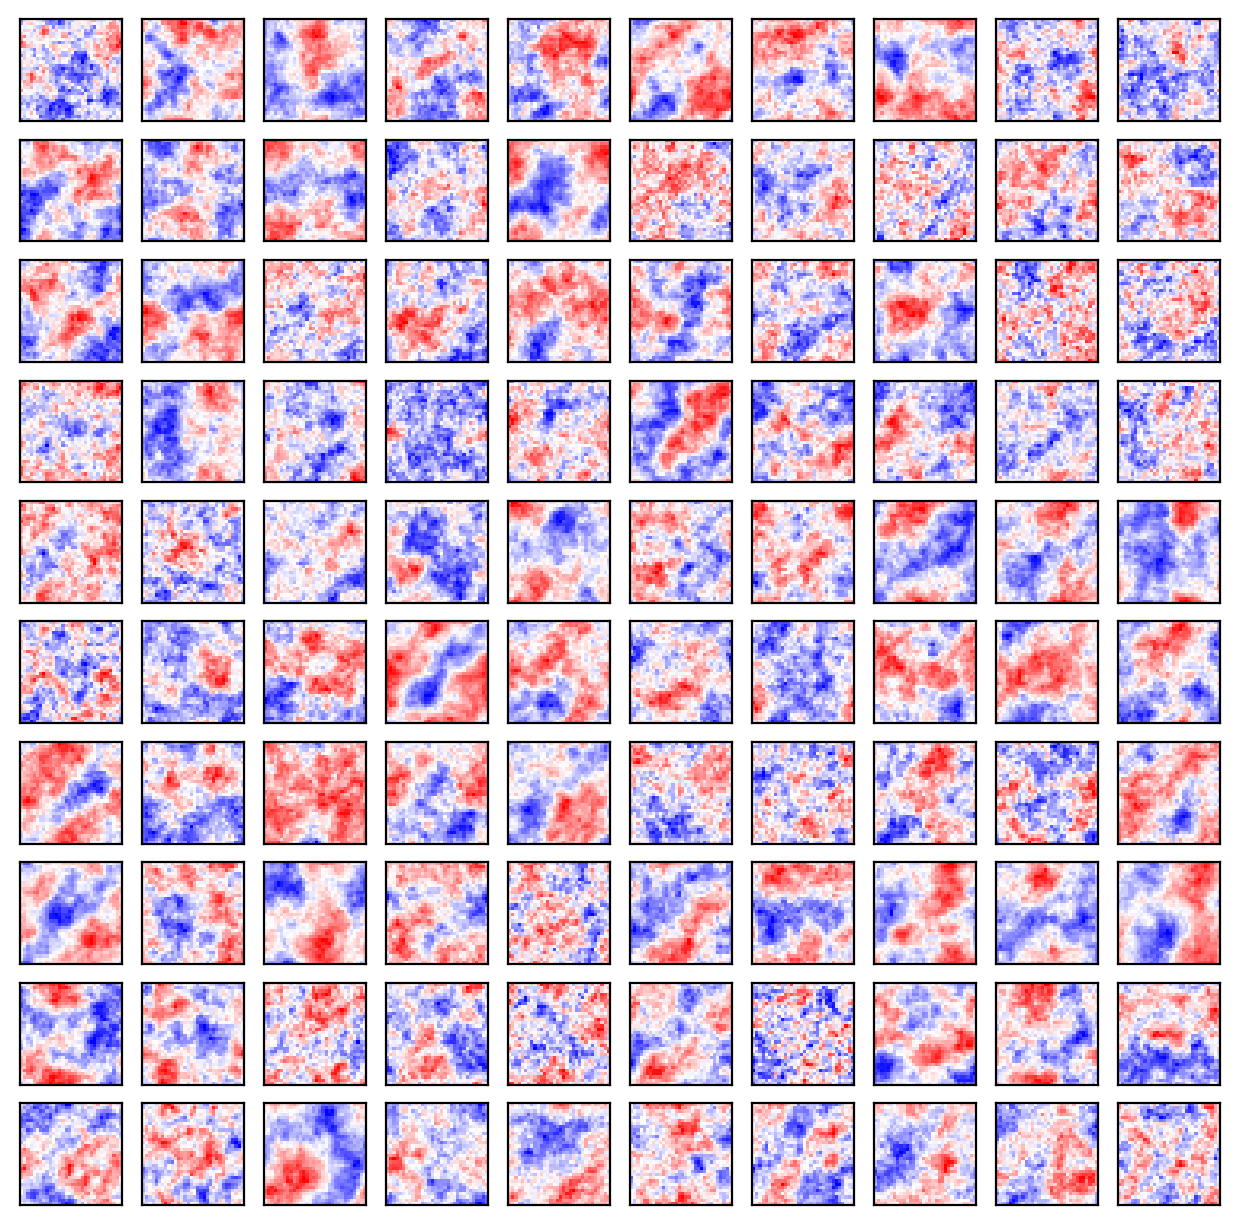

In [5]:
n_draws = 5000

fig, axd = plt.subplot_mosaic(
    np.asarray([str(n) for n in range(100)]).reshape(10, 10), 
    figsize=(6., 6.),
    dpi=200,
    subplot_kw={"xticks" : [], "yticks" : []},
    gridspec_kw={
        "hspace" : 0.04, "left" : 0.0, "right" : 1.0, "top" : 1., "bottom" : 0.
    }
)

fields = np.zeros((n_sims, n_pix, n_pix))
for i, y in enumerate(parameters):
    if i >= n_draws:
        break
    A, B = y
    pk_fn = lambda k: A * k ** -B
    field = make_gaussian_random_field(n_pix, box_dim, pk_fn, random_seed=i)
    fields[i] = field
    print(f"\r{i=} {field.max()=}, {field.min()=}", end="")
    if i < 100:
        axd[str(i)].imshow(field, cmap="bwr")

# Unpack true parameters, parameterise power spectrum model using them
A, B = AB
pk_fn = lambda k: A * k ** -B

# Make a measurement using the true parameters
data = make_gaussian_random_field(n_pix, box_dim, pk_fn, random_seed=128973874)

In [6]:
print(fields.shape)
print(A.shape)
print(B.shape)
print(parameters.shape)

(5000, 32, 32)
()
()
(5000, 2)


## Making the autoencoder

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np

# Check if GPU is available
if torch.cuda.is_available():
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")

    # Get the name of the GPU device(s)
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU is not available. Running on CPU.")


GPU is available
Number of GPUs: 1
GPU Name: NVIDIA A40


In [8]:


# Define the Autoencoder architecture
class AutoEncoder(nn.Module):
    def __init__(self, data_dim, z_dim, hidden_dim=128):
        super(AutoEncoder, self).__init__()

        self.data_shape_out = tuple(int(np.ceil(l / 4)) for l in data_dim[1:])  # Use np.ceil to avoid zero size
        self.data_dim_out = int(np.prod(self.data_shape_out))  # Downsampling size
        self.hidden_dim = hidden_dim

        conv_kwargs = dict(padding=1, kernel_size=3, stride=2)

        # Encoding layers
        self.conv1 = nn.Conv2d(
            in_channels=1, out_channels=int(hidden_dim / 2), bias=False, **conv_kwargs
        )
        self.conv2 = nn.Conv2d(
            in_channels=int(hidden_dim / 2), out_channels=hidden_dim, bias=False, **conv_kwargs
        )
        self.linear1 = nn.Linear(
            in_features=hidden_dim * self.data_dim_out, out_features=z_dim
        )

        # Decoding layers
        self.linear2 = nn.Linear(
            in_features=z_dim, out_features=hidden_dim * self.data_dim_out
        )
        self.convt1 = nn.ConvTranspose2d(
            in_channels=hidden_dim, out_channels=int(hidden_dim / 2), output_padding=1, **conv_kwargs
        )
        self.convt2 = nn.ConvTranspose2d(
            in_channels=int(hidden_dim / 2), out_channels=1, output_padding=1, **conv_kwargs
        )

    def forward(self, x):
        emb = self.encoder(x)
        _x = self.decoder(emb)
        return _x, emb

    def decoder(self, emb):
        _x = self.linear2(emb)
        _x = F.dropout(_x, p=0.2, training=self.training)
        _x = torch.tanh(_x)
        _x = _x.view(-1, self.hidden_dim, *self.data_shape_out)
        _x = self.convt1(_x)
        _x = F.dropout(_x, p=0.2, training=self.training)
        _x = torch.tanh(_x)
        _x = self.convt2(_x)
        _x = torch.tanh(_x)
        return _x

    def encoder(self, x):
        # print(x.shape)
        _x = self.conv1(x)
        _x = F.dropout(_x, p=0.2, training=self.training)
        _x = torch.tanh(_x)
        _x = self.conv2(_x)
        _x = F.dropout(_x, p=0.2, training=self.training)
        _x = torch.tanh(_x)
        # print(_x.shape)
        _x = torch.flatten(_x, 1)
        # print(_x.shape)
        emb = self.linear1(_x)
        return emb

In [9]:
# Convert GRF data to PyTorch tensors
grf_tensor = torch.tensor(fields, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for convolution

# Normalize data
grf_tensor = (grf_tensor - grf_tensor.min()) / (grf_tensor.max() - grf_tensor.min())

In [10]:
# Define DataLoader
batch_size = 64
data_loader = DataLoader(TensorDataset(grf_tensor.cuda()), batch_size=batch_size, shuffle=True)

In [11]:
# Initialize the Autoencoder, loss function, and optimizer
input_dim = grf_tensor.shape[1:]
print(f"Input dimensions: {input_dim}")  # Debug print
hidden_dim = 64
latent_dim = 16

Input dimensions: torch.Size([1, 32, 32])


In [12]:
# Instantiate the AutoEncoder
autoencoder = AutoEncoder(input_dim, latent_dim, hidden_dim).cuda()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

In [13]:
# Check if there are any zero-element tensors
for name, param in autoencoder.named_parameters():
    if param.numel() == 0:
        print(f"Warning: Parameter '{name}' has zero elements.")
    else:
        print(f"Parameter '{name}' shape: {param.shape}")

Parameter 'conv1.weight' shape: torch.Size([32, 1, 3, 3])
Parameter 'conv2.weight' shape: torch.Size([64, 32, 3, 3])
Parameter 'linear1.weight' shape: torch.Size([16, 4096])
Parameter 'linear1.bias' shape: torch.Size([16])
Parameter 'linear2.weight' shape: torch.Size([4096, 16])
Parameter 'linear2.bias' shape: torch.Size([4096])
Parameter 'convt1.weight' shape: torch.Size([64, 32, 3, 3])
Parameter 'convt1.bias' shape: torch.Size([32])
Parameter 'convt2.weight' shape: torch.Size([32, 1, 3, 3])
Parameter 'convt2.bias' shape: torch.Size([1])


## Training the AE

Epoch [1/100], Loss: 0.0289, Time: 2.76 seconds


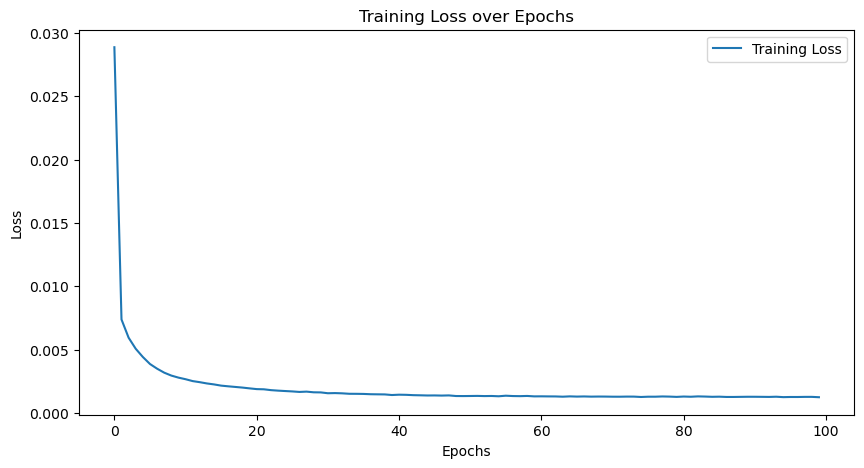

In [14]:
# Training loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import time

num_epochs = 100
loss_history = []

for epoch in range(num_epochs):
    autoencoder.train()
    total_loss = 0.0
    start_time = time.time()
    for batch in data_loader:
        optimizer.zero_grad()
        batch = batch[0].to(device)
        reconstructed, _ = autoencoder(batch)
        loss = criterion(reconstructed, batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    average_loss = total_loss / len(data_loader)
    loss_history.append(average_loss)
    if epoch % 100 == 0:
        epoch_time = time.time() - start_time  # Calculate epoch time
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {average_loss:.4f}, Time: {epoch_time:.2f} seconds')

# Save the trained autoencoder
torch.save(autoencoder.state_dict(), 'grf_autoencoder.pth')

# Plot the loss chart
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


In [16]:
autoencoder = AutoEncoder(input_dim, latent_dim, hidden_dim).cuda()
autoencoder.load_state_dict(torch.load('grf_autoencoder.pth'))
autoencoder.eval()

AutoEncoder(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (linear1): Linear(in_features=4096, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=4096, bias=True)
  (convt1): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (convt2): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
)

## Reconstruction

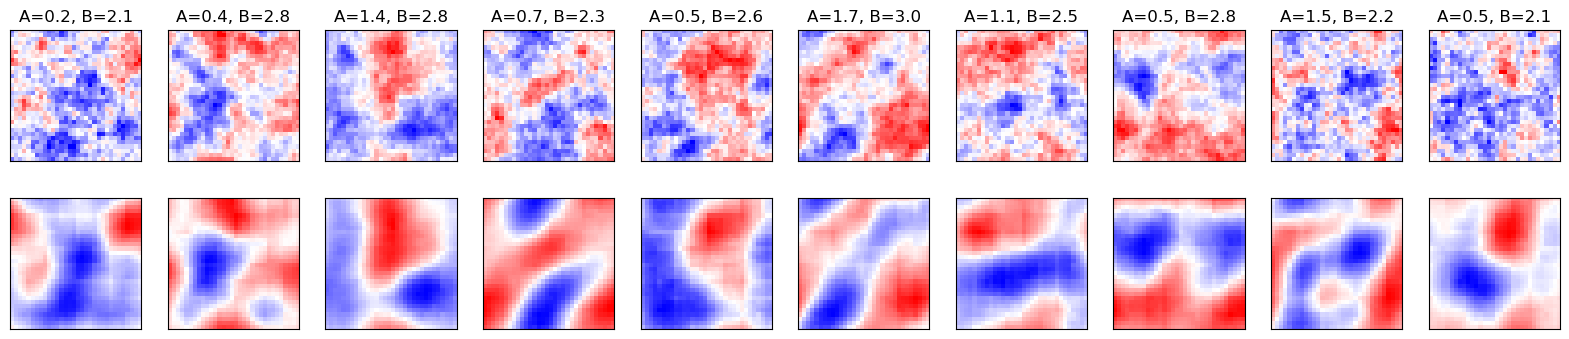

In [17]:
test_fields = fields  # Load or define your test data here

# Convert test data to PyTorch tensors
test_tensor = torch.tensor(test_fields, dtype=torch.float32).unsqueeze(1)  # Add channel dimension for convolution

# Normalize test data
test_tensor = (test_tensor - test_tensor.min()) / (test_tensor.max() - test_tensor.min())

# Pass test data through the autoencoder to get reconstructed output
with torch.no_grad():
    test_tensor = test_tensor.cuda()
    reconstructed, embeddings = autoencoder(test_tensor)

# Convert reconstructed data back to numpy for further processing or visualization
reconstructed_np = reconstructed.cpu().numpy()

# Plot original and reconstructed images for comparison
n = 10  # Number of samples to display

A = parameters[:,0]
B = parameters[:,1]


plt.figure(figsize=(20, 4))


for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_tensor[i].cpu().numpy().squeeze(), cmap='bwr')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(f"A={A[i]:.1f}, B={B[i]:.1f}")  # Add title
    
    # Display reconstruction
    
    ax = plt.subplot(2, n, i + 1 + n)
    
    plt.imshow(reconstructed_np[i].squeeze(), cmap='bwr')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [18]:
print(embeddings.shape)

torch.Size([5000, 16])


In [19]:
print(embeddings[:5])

tensor([[-0.1504,  0.1039, -0.2732, -0.1844,  0.3130, -0.3435,  0.4106, -0.1765,
         -0.1676,  0.1425,  0.1946,  0.0589,  0.1049,  0.2453, -0.2235, -0.0534],
        [-0.1220,  0.0555, -0.3298, -0.1751,  0.2981, -0.3886,  0.3376, -0.2638,
         -0.1856,  0.1541,  0.1966,  0.1463,  0.1622,  0.2649, -0.2694, -0.0679],
        [-0.1011,  0.1489, -0.3052, -0.1680,  0.2537, -0.4707,  0.4008, -0.2912,
         -0.1812,  0.1376,  0.2066,  0.2260,  0.2340,  0.1558, -0.1635, -0.0788],
        [-0.1132,  0.2074, -0.2986, -0.1860,  0.1377, -0.3821,  0.4281, -0.2324,
         -0.2072,  0.1891,  0.3223,  0.0718,  0.0972,  0.3022, -0.3142, -0.0778],
        [-0.0954,  0.0983, -0.3031, -0.1248,  0.2565, -0.3699,  0.3381, -0.2273,
         -0.1939,  0.1163,  0.2263,  0.1511,  0.1290,  0.1734, -0.2368, -0.0042]],
       device='cuda:0')


In [20]:
print(embeddings.dtype)

torch.float32


In [21]:
A.shape

(5000,)

In [22]:
B.shape

(5000,)